# Wilson Cowan Tutorial

In this tutorial, we will be learning how to use NeuroTorch to train a recurrent neural network that reproduce time series using the Wilson-Cowan dynamic.

**Plan of this notebook**
1. Brief introduction to the theory behind the Wilson-Cowan dynamic
2. Setup
3. How to create Dataset and dataloader
4. Setting up our data
5. How to run the training
6. Tools to visualise the trained data
7. Stacking multiple layers

---

### 1 - Wilson-Cowan dynamic

Introduce in 1972 by Wilson HR and Cowan JD, the Wilson-Cowan dynamic performs well when it comes to reproducing and predicting calcium neuronal activity. The equation used is the following :

# <center> $\tau \dot{\vec{x}} = -\vec{x} + (1 - \vec{r} \odot \vec{x}) \odot \sigma({\mathbf{W}\vec{x} - \vec{\mu}})$

We can apply Euler's discretisation. By doing so, we obtain :

# <center> $\vec{x}_{(t+1)} = \vec{x}_{(t)}\left(1- \frac{\Delta t}{\tau}\right) + \frac{\Delta t}{\tau}\left(\left(1 - \vec{r}\odot\vec{x}_{(t)}\right)\odot\sigma\left(\mathbf{W}\vec{x}_{(t)} - \vec{\mu}\right)\right)$


However, in NeuroTorch, we slightly modify this equation to allow to use of batches and to be coherent with format that what use in the rest of the module. In neuroscience, it is common to represent the neuronal activity with a matrix ($N$ x $T$) where $N$ is the number of neurons and $T$ is the number of time step. However, in NeuroTorch, we use the following convention : ($B$ x $T$ x $N$) where $B$ is the number of batch. In this notebook, our goal is to reproduce a specific time series, therefore, our batch size will be $B = 1$. We therefore apply a transpose on our weight matrix and inputs. With this in mind, the Wilson-Cowan becomes :

# <center> $\vec{x}_{(t+1)} = \vec{x}_{(t)}\left(1 - \frac{\Delta t}{\tau}\right) + \frac{\Delta t}{\tau}\left(\left(1 - \vec{r}\odot\vec{x}_{(t)}\right)\odot \sigma\left(\vec{x}_{(t)}\mathbf{W} - \vec{\mu}\right)\right)$

By doing so, we obtain the same result but we are now using an equation that follow what have been done so far in NeuroTorch.

Now, let us define the different parameters of this equation:

- $\vec{x}$ is the neuronal activity at a time $t$ (normalized between 0 and 1) of size (1 x $N$)
- $\Delta t$ is the time step of integration
- $\tau$ is the characteristic time. It represents the time needed for the neuronal activity to decay
- $\vec{r}$ is the refractory time. It represents the time needed for a neuron to fire again once she has already fired of size (1 x $N$)
- $\sigma$ is the sigmoid function
- $W$ is the weight connexion (connectome) of size ($N$ x $N$). $W_{ij}$ tell us how neuron $i$ is connected to neuron $j$
- $\mu$ is the activation threshold of size (1 x $N$). It represents the input needed for a neuron to fire. A neuron with a small $\mu$ will be sensitive to input and will easily fire.

One may notice that hidden states were not discussed here. When working with one layer, this is not an issue. However, at the end of this tutorial, we will show how you can use multiple layers. Hidden states will then need to be discussed there.

---

### 2 - Setup

For those not familiar with Python and virtual environment, you can:

- Follow those steps if you understand french : [venv and pycharm](https://github.com/JeremieGince/TutorielPython-Manuel/tree/master/Environments)

- For english speaker : TODO

Once may notice that

In [ ]:
%%capture
!pip install -r time_series_forcasting_wilson_cowan_requirements.txt
!pip install git+https://github.com/JeremieGince/NeuroTorch.git

If you have a cuda device and want to use it for this tutorial, you can uninstall pytorch with `pip uninstall torch` and re-install it with the right cuda version by generating a command with [PyTorch GetStarted](https://pytorch.org/get-started/locally/) web page. However, for this notebook, we recommend using CPU since we are not using batches.

After setting up the virtual environment, we will need to import the necessary packages.

These are the packages that will be needed for NeuroTorch:

In [2]:
%%capture
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import neurotorch as nt
from neurotorch.metrics import RegressionMetrics
from neurotorch.visualisation.time_series_visualisation import Visualise, VisualiseKMeans
from neurotorch.regularization.connectome import DaleLawL2
from neurotorch import WilsonCowanLayer
from src.neurotorch.transforms.base import to_tensor

---
### 3 - Dataset & Dataloader

When working with PyTorch, it is important to define a dataset and a dataloader. Of course, you can always use the one that are provided in this module. However, you might be interested in knowing how those simple class are built. With NeuroTorch, multiple datasets and dataloader are already built-in depending on what you need. Dataset are used to prepare your datas to be used in NeuroTorch. For instance, dataset are used to inform NeuroTorch on the transformation you want to apply to you data or the ratio of datas that will be used to training and to evaluate the quality of the training.

1. First, you begin by creating the constructor
2. You redefine the <code>\_\_len\_\_</code> operator. It returns the size of the dataset
3. You redefine the <code>\_\_getitem__</code> operator. You want to be able to use indexing such as <code> dataset[i] </code> can be use to get the *i*th sample in your dataset. You return the value needed for training and testing.

In our case, we have a dataset of size 1 (one sample) since we only use one time series. Also, when defining <code>\_\_getitem__</code>, we will return the initial condition and the rest of the timeseries since we only have one dataset. We unsqueeze the initiale condition so the tensor goes from size [$N$] to size [1 x $N$]. Remember that, in this dataset, your time series must have the size [$T$ x $N$]

In [5]:
class WCDataset(Dataset):
	def __init__(self, x):
		self.x = x

	def __len__(self):
		return 1

	def __getitem__(self, item):
		return torch.unsqueeze(self.x[0], dim=0), self.x[1:]

For the dataloader, we can simply use the dataloader built in PyTorch. Sometime, it is interesting to build our own. If this case applies to you, feel free look at a few dataloaders and datasets that were built for WilsonCowan in application/time_series_forecasting_wilson_cowan/dataset

---
### 4 - Setting up our data

This section depend heavily on the way you have your data. For this tutorial, we will use a neuronal activity from a zebra fish. We will take 200 random neurons in our dataset. In this dataset, 406 time steps are present. We begin by importing the data :



In [6]:
import numpy as np

time_series = np.load('timeSeries_2020_12_16_cr3_df.npy')
n_neurons, n_shape = time_series.shape
sample_size = 200
sample = np.random.randint(n_neurons, size=sample_size)
data = time_series[sample, :]

To improve the training, one might also want to smooth the data :

In [8]:
from scipy.ndimage import gaussian_filter1d

sigma = 30

for neuron in range(data.shape[0]):
	data[neuron, :] = gaussian_filter1d(data[neuron, :], sigma=sigma)
	data[neuron, :] = data[neuron, :] - np.min(data[neuron, :])
	data[neuron, :] = data[neuron, :] / np.max(data[neuron, :])



---
### 5 - Training the data

To reproduce a time series, you can follow those easy steps :

1. Think about the parameters of your training. What kind of optimizer, learning rate, regularisation ...
2. Define your function <code> train_with_params </code>
3. Run the code!

With NeuroTorch, you can easily use the optimizer, loss function, regularisation ... that you want! However, when it comes to reproducing time series, we have selected the one that performs the best. For this tutorial, we will use those.

#### Defining <code> train_with_params </code>

As you can see, until now, very few lines of codes were needed. <code> train_with_params </code> is the only function that must be definie by the user because this is where you tell NeuroTorch the parameters you wish to use. We will walk you through the process, so you can easily recreate this function or even modify to fit your needs. <code> train_with_params </code> takes 3 kind of entries :

- Training related arguments
- Wilson-Cowan dynamic arguments
- device to compute

Generally, you want your argument to be aspect of your training that might change from training to training. For instance, if you're planinng on always using the same learning rate, you might want to remove learning rate from <code> train_with_params </code> and directly add this parameters in the code rather than as an arguments. Of course, the opposite can also be done.

In [9]:
from typing import Optional

def train_with_params(
		true_time_series: np.ndarray or torch.Tensor,
		learning_rate: float = 1e-2,
		epochs: int = 100,
		forward_weights: Optional[torch.tensor or np.ndarray] = None,
		std_weights: float = 1.0,
		dt: float = 0.02,
		mu: Optional[float or torch.Tensor or np.ndarray] = 0.0,
		mean_mu : Optional[float] = 0.0,
		std_mu: Optional[float] = 1.0,
		r: Optional[float or torch.Tensor or np.ndarray] = 1.0,
		mean_r: Optional[float] = 1.0,
		std_r: Optional[float] = 1.0,
		tau: float = 1.0,
		learn_mu: bool = False,
		learn_r: bool = False,
		learn_tau: bool = False,
		device: torch.device = torch.device("cpu")
):
	pass

From there, we can build this function by following these steps :

1. Initialise layer
2. Initialise sequential
3. Initialise trainer

##### Step 1.

When initialising the layer, you can specify the initial parameter of the Wilson-Cowan. If a parameter has not received an argument, it will be generated randomly. The forward weights is the main parameter that is trained. If you want, you can also train the parameter r, $\mu$ and $\tau$. Also, you might want to give an initial forward weight that follow some biological properties to accelerate the training.

In [30]:
def train_with_params(
		true_time_series: np.ndarray or torch.Tensor,
		learning_rate: float = 1e-3,
		epochs: int = 100,
		forward_weights: Optional[torch.Tensor or np.ndarray] = None,
		std_weights: float = 1,
		dt: float = 1e-3,
		mu: Optional[float or torch.Tensor or np.ndarray] = 0.0,
		mean_mu: Optional[float] = 0.0,
		std_mu: Optional[float] = 1.0,
		r: Optional[float or torch.Tensor or np.ndarray] = 1.0,
		mean_r: Optional[float] = 1.0,
		std_r: Optional[float] = 1.0,
		tau: float = 1.0,
		learn_mu: bool = False,
		learn_r: bool = False,
		learn_tau: bool = False,
		device: torch.device = torch.device("cpu"),
		hh_init: str = "inputs"
):
	if not torch.is_tensor(true_time_series):
		true_time_series = torch.tensor(true_time_series, dtype=torch.float32, device=device)
	ts = true_time_series.T[np.newaxis, :]
	ws_layer = WilsonCowanLayer(
		ts.shape[-1], ts.shape[-1],
		forward_weights=forward_weights,
		std_weights=std_weights,
		dt=dt,
		r=r,
		mean_r=mean_r,
		std_r=std_r,
		mu=mu,
		mean_mu=mean_mu,
		std_mu=std_mu,
		tau=tau,
		learn_r=learn_r,
		learn_mu=learn_mu,
		learn_tau=learn_tau,
		hh_init=hh_init,
		device=device,
		name="WilsonCowan_layer1"
	)
	pass

##### Step 2.

We will now add the sequential model. Here, you want to add the layer you have, the device on which you will compute and the foresight time step. Please note that the foresight time step is the number of time step that will be predicted from the initial condition. Since we are trying to reproduce the time series, we want as much time step as the data. Our foresight time step will therefore be the total time step number of our data minus one (to remove the initial condition). After that, you build the model so that the parameter that will be trained can be initialized. We now have :

In [31]:
def train_with_params(
		true_time_series: np.ndarray or torch.Tensor,
		learning_rate: float = 1e-2,
		epochs: int = 100,
		forward_weights: Optional[torch.tensor or np.ndarray] = None,
		std_weights: float = 1.0,
		dt: float = 0.02,
		mu: Optional[float or torch.Tensor or np.ndarray] = 0.0,
		mean_mu : Optional[float] = 0.0,
		std_mu: Optional[float] = 1.0,
		r: Optional[float or torch.Tensor or np.ndarray] = 1.0,
		mean_r: Optional[float] = 1.0,
		std_r: Optional[float] = 1.0,
		tau: float = 1.0,
		learn_mu: bool = False,
		learn_r: bool = False,
		learn_tau: bool = False,
		device: torch.device = torch.device("cpu")
):
	if not torch.is_tensor(true_time_series):  # convert time series to torch tensor
		true_time_series = torch.tensor(true_time_series, dtype=torch.float32, device=device)
	ts = true_time_series.T  # ensure that time series has format (1 x T x N)
	wc_layer = WilsonCowanLayer(
		ts.shape[-1], ts.shape[-1],
		forward_weights=forward_weights,
		std_weights=std_weights,
		dt=dt,
		r=r,
		mean_r=mean_r,
		std_r=std_r,
		mu=mu,
		mean_mu=mean_mu,
		std_mu=std_mu,
		tau=tau,
		learn_r=learn_r,
		learn_mu=learn_mu,
		learn_tau=learn_tau,
		device=device,
		name="WilsonCowan"
	)

	model = nt.SequentialModel(layers=[wc_layer], device=device, foresight_time_steps=ts.shape[1] - 1)
	model.build()
	pass

##### Step 3.

To add the trainer, we simply definie the optimizer for the parameter and the regularisation (if we wish to have regularisation). The following regularisation will be applied on the connectome :

<center> $\min_{W} = Tr(W^T(\alpha * W - (1 - \alpha)W_{EI}))$ </center>

The parameter $\alpha$ is a parameter between 0 and 1 that define whether the regularisation is the dale law ($\alpha = 0$), a reduction of the connectome ($\alpha = 1$) or a combination of both. Also, $W_{EI}$ is a reference matrix that must follow dale's law and will guide the optimizer. Please note that the regularisation of the connectome has a separate optimizer. The loss function that is used here is the proportion of variance :
<center> $pVar = 1 - \frac{MSE(x,y)}{var{(x)}}$ </center>

This loss function is define between $-\infty$ and $1$. We want to maximise it.

To use the Dale's law L2 regularisation, a reference connectome that is already following Dale's law needs to be applied. Also, further down the road, it will be interesting to begin the training with a random matrix that follows Dale's law rather than "just" a random matrix. To do so, you can use the <code> init </code> option. With this, a connectome can be easily initialize. To do, <code> init.dale_ </code> needs a sample connectome with the correct size, the ratio between inhibitory and excitation neurons. Finally, the density of connection can be given.

In [10]:
nt.init.dale_(torch.zeros(200, 200), inh_ratio=0.5, rho=0.99)

tensor([[-0.1300, -0.5565, -1.1680,  ..., -1.2250, -0.0172, -0.8726],
        [-0.3957, -0.1531, -0.5298,  ..., -0.1836, -0.6291, -0.6209],
        [-0.0494, -0.1964, -0.1108,  ..., -0.8162, -0.6022, -0.0466],
        ...,
        [ 0.4566,  0.8753,  0.1256,  ...,  0.0574,  1.9139,  0.3085],
        [ 0.2092,  0.8907,  0.0495,  ...,  0.4788,  0.1786,  0.9711],
        [ 0.1024,  0.2720,  0.0472,  ...,  1.1630,  0.8637,  0.9976]])

Once this step is complete. We will have a well functioning training.

In [11]:
def train_with_params(
		true_time_series: np.ndarray or torch.Tensor,
		learning_rate: float = 1e-2,
		epochs: int = 100,
		forward_weights: Optional[torch.tensor or np.ndarray] = None,
		std_weights: float = 1.0,
		dt: float = 0.02,
		mu: Optional[float or torch.Tensor or np.ndarray] = 0.0,
		mean_mu : Optional[float] = 0.0,
		std_mu: Optional[float] = 1.0,
		r: Optional[float or torch.Tensor or np.ndarray] = 1.0,
		mean_r: Optional[float] = 1.0,
		std_r: Optional[float] = 1.0,
		tau: float = 1.0,
		learn_mu: bool = False,
		learn_r: bool = False,
		learn_tau: bool = False,
		device: torch.device = torch.device("cpu")
):
	if not torch.is_tensor(true_time_series):  # convert time series to torch tensor
		true_time_series = torch.tensor(true_time_series, dtype=torch.float32, device=device)
	ts = true_time_series.T  # ensure that time series has format (1 x T x N)
	wc_layer = WilsonCowanLayer(
		ts.shape[-1], ts.shape[-1],
		forward_weights=forward_weights,
		std_weights=std_weights,
		dt=dt,
		r=r,
		mean_r=mean_r,
		std_r=std_r,
		mu=mu,
		mean_mu=mean_mu,
		std_mu=std_mu,
		tau=tau,
		learn_r=learn_r,
		learn_mu=learn_mu,
		learn_tau=learn_tau,
		device=device,
		name="WilsonCowan"
	)

	model = nt.SequentialModel(layers=[wc_layer], device=device, foresight_time_steps=ts.shape[0] - 1)
	model.build()

	regularisation = DaleLawL2([wc_layer.forward_weights], alpha=0.5,
							   reference_weights=[nt.init.dale_(torch.zeros(200, 200), inh_ratio=0.5, rho=0.99)])
	optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, maximize=True, weight_decay=0.1)  # Weight decay can be applied to reduce the energy if connectome

	optimizer_regul = torch.optim.SGD(regularisation.parameters(), lr=5e-4)
	dataset = WCDataset(ts)
	trainer = nt.trainers.RegressionTrainer(
		model,
		optimizer=optimizer,
		regularization_optimizer=optimizer_regul,
		criterion=lambda pred, true: RegressionMetrics.compute_p_var(y_true=true, y_pred=pred),
		regularisation=regularisation,
		metrics=[regularisation]
	)
	trainer.train(
		DataLoader(dataset, shuffle=False, num_workers=0),
		n_iterations=epochs,
		exec_metrics_on_train=True
	)

It is now time to call the function and train our data!

In [12]:
initial_forward_weight = nt.init.dale_(torch.zeros(200, 200), inh_ratio=0.5, rho=0.2)

result = train_with_params(
	true_time_series=data,
	learning_rate=1e-2,
	epochs=500,
	forward_weights=initial_forward_weight,
	std_weights=1,
	dt=0.02,
	mu=0.0,
	mean_mu=0,
	std_mu=1,
	r=0.1,
	mean_r=0.2,
	std_r=0,
	tau=0.1,
	learn_mu=True,
	learn_r=True,
	learn_tau=True,
	device=torch.device("cpu")
)

Training:   0%|          | 0/500 [00:00<?, ?itr/s]

---
### 6 - Visualise data

Now, we might want to extract the trained parameters such as the connectome to visualise them. We will slightly modify our function train_with params to extract the trained value. We will use the class Visualise that allows us to plot our data in numerous way such as heatmap or ridgeplot.

In [14]:
def train_with_params(
		true_time_series: np.ndarray or torch.Tensor,
		learning_rate: float = 1e-2,
		epochs: int = 100,
		forward_weights: Optional[torch.tensor or np.ndarray] = None,
		std_weights: float = 1.0,
		dt: float = 0.02,
		mu: Optional[float or torch.Tensor or np.ndarray] = 0.0,
		mean_mu : Optional[float] = 0.0,
		std_mu: Optional[float] = 1.0,
		r: Optional[float or torch.Tensor or np.ndarray] = 1.0,
		mean_r: Optional[float] = 1.0,
		std_r: Optional[float] = 1.0,
		tau: float = 1.0,
		learn_mu: bool = False,
		learn_r: bool = False,
		learn_tau: bool = False,
		device: torch.device = torch.device("cpu")
):
	if not torch.is_tensor(true_time_series):  # convert time series to torch tensor
		true_time_series = torch.tensor(true_time_series, dtype=torch.float32, device=device)
	ts = true_time_series.T  # ensure that time series has format (1 x T x N)
	wc_layer = WilsonCowanLayer(
		ts.shape[-1], ts.shape[-1],
		forward_weights=forward_weights,
		std_weights=std_weights,
		dt=dt,
		r=r,
		mean_r=mean_r,
		std_r=std_r,
		mu=mu,
		mean_mu=mean_mu,
		std_mu=std_mu,
		tau=tau,
		learn_r=learn_r,
		learn_mu=learn_mu,
		learn_tau=learn_tau,
		device=device,
		name="WilsonCowan"
	)

	model = nt.SequentialModel(layers=[wc_layer], device=device, foresight_time_steps=ts.shape[0] - 1)
	model.build()

	regularisation = DaleLawL2([wc_layer.forward_weights], alpha=0.5,
							   reference_weights=[nt.init.dale_(torch.zeros(200, 200), inh_ratio=0.5, rho=0.99)])
	optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, maximize=True, weight_decay=0.1)  # Weight decay can be applied to reduce the energy if connectome

	optimizer_regul = torch.optim.SGD(regularisation.parameters(), lr=5e-4)
	dataset = WCDataset(ts)
	trainer = nt.trainers.RegressionTrainer(
		model,
		optimizer=optimizer,
		regularization_optimizer=optimizer_regul,
		criterion=lambda pred, true: RegressionMetrics.compute_p_var(y_true=true, y_pred=pred),
		regularisation=regularisation,
		metrics=[regularisation]
	)
	trainer.train(
		DataLoader(dataset, shuffle=False, num_workers=0),
		n_iterations=epochs,
		exec_metrics_on_train=True
	)

	out = {}
	out["W"] = wc_layer.forward_weights.detach().cpu().numpy().T  # Back to (neuron i <- neuron j)
	out["mu"] = wc_layer.mu.detach().numpy()
	out["r"] = wc_layer.r.detach().numpy()
	out["tau"] = wc_layer.tau.detach().numpy()
	x_pred = []
	initial_condition = ts[None, :]
	x_pred.append(torch.unsqueeze(initial_condition[:, 0].clone(), dim=1).to(model.device))
	x_pred.append(model.get_prediction_trace(x_pred[0]))
	x_pred = torch.concat(x_pred, dim=1)
	out["x_pred"] = torch.squeeze(x_pred).detach().numpy().T  # We put it back in the classic format (N x T)

	return out

In [15]:
initial_forward_weight = nt.init.dale_(torch.zeros(200, 200), inh_ratio=0.5, rho=0.2)

res = train_with_params(
	true_time_series=data,
	learning_rate=1e-2,
	epochs=500,
	forward_weights=initial_forward_weight,
	std_weights=1,
	dt=0.02,
	mu=0.0,
	mean_mu=0,
	std_mu=1,
	r=0.1,
	mean_r=0.2,
	std_r=0,
	tau=0.1,
	learn_mu=True,
	learn_r=True,
	learn_tau=True,
	device=torch.device("cpu")
)

Training:   0%|          | 0/500 [00:00<?, ?itr/s]

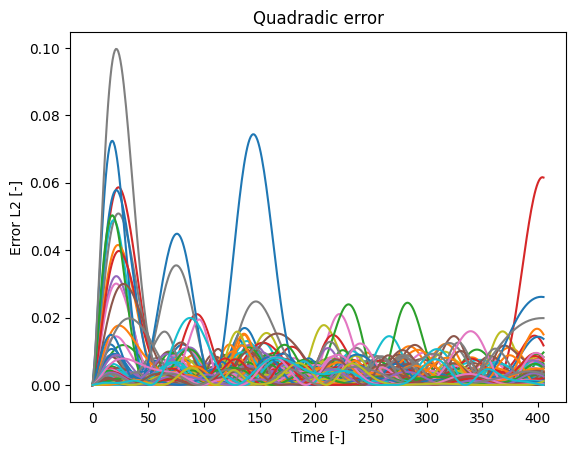

In [16]:
import matplotlib.pyplot as plt

error = (res["x_pred"] - data) ** 2
plt.plot(error.T)
plt.title(f"Quadradic error")
plt.xlabel("Time [-]")
plt.ylabel("Error L2 [-]")
plt.show()

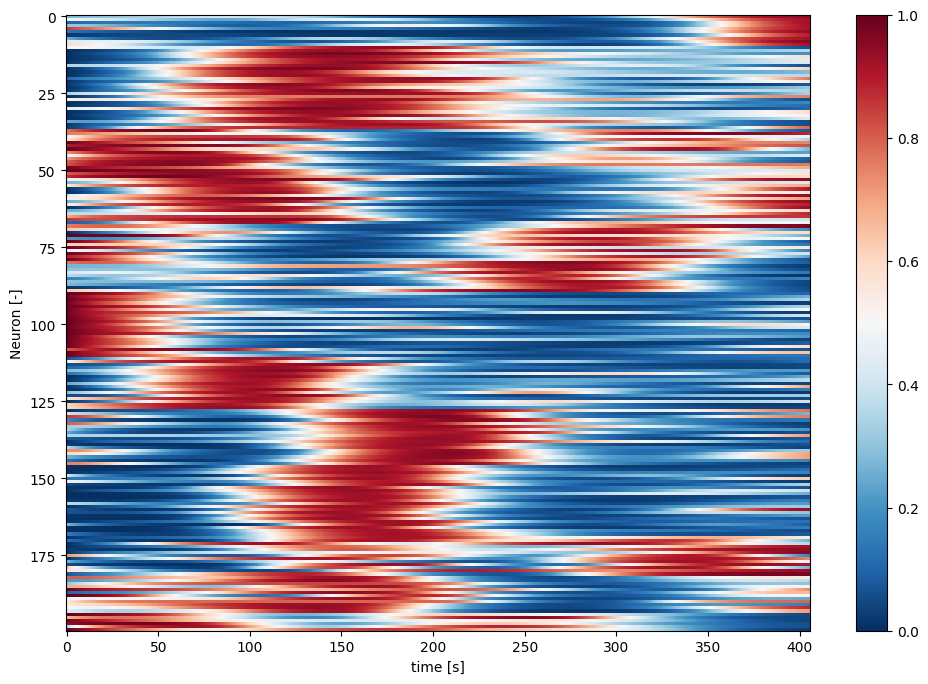

In [17]:
VisualiseKMeans(res["x_pred"], nt.Size([nt.Dimension(200, nt.DimensionProperty.NONE, "Neuron [-]"), nt.Dimension(406, nt.DimensionProperty.TIME, "time [s]")])).heatmap(show=True)

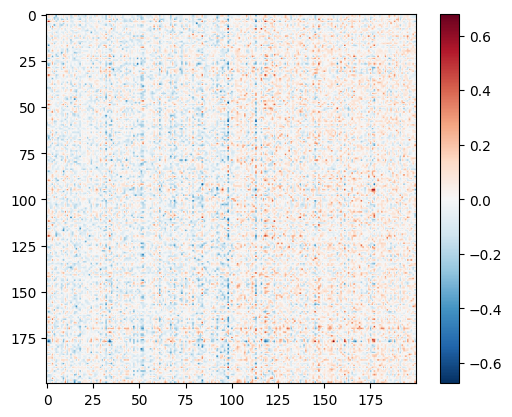

In [18]:
plt.imshow(res["W"], cmap="RdBu_r")
plt.colorbar()
plt.show()

---
### 7 - Stacking multiple layers

If the goal of the training is to extract a realistic connectome, that it is important to use one layer as shown previously. However, we can stack multiple layers to reproduce/predict the time step. Hence, if the goal is to reproduce and/or predict data without extracting a connectome, then adding layers might be a good idea since it is possible to get more abstract representation of the data. Therefore, it is possible to better approximate complex functions that might explain the data.

With **NeuroTorch**, it is rather easy to add *N* supplementary layers. To add more layers :

1- Chose how the hidden states are initialized.
2- Create *N* objects <code>WilsonCowanLayer</code> (If a deepcopy is made, you must change the name of the new one!)
3- Apply regularisation on the different connectome (if desired)

#### Step 1 : hidden states

When dealing with multiple layers, you must use hidden states to ensure that your Euler integration is done properly. In section 1, we have shown the equation that was implemented in NeuroTorch. However, the equation that was *actually* is slightly different to ensure that hidden states and multi-layers training is working correctly. The *actual* equation is :

# <center> $\vec{x}_{(t+1)} = \vec{h}_{(t)}\left(1 - \frac{\Delta t}{\tau}\right) + \frac{\Delta t}{\tau}\left(\left(1 - \vec{r}\odot\vec{h}_{(t)}\right)\odot \sigma\left(\vec{h}_{(t)}\mathbf{W}^{\text{rec}}\vec{x}_{(t)}\mathbf{W} - \vec{\mu}\right)\right)$

The new terms can be defined in the following way :

- $\mathbf{W}^{\text{rec}}$ is the recurrent matrix of size (output x output)
- $\vec{h}_{(t)}$ is the hidden state at a time $t$

With **NeuroTorch**, you can initialise the hidden states with zeros, with random numbers or with the actual inputs. In facts, when working with one layer, the hidden states are initialise with the inputs. Therefore, $\vec{h}_{(t)} = \vec{x}_{(t)}$ and $\mathbf{W}^{\text{rec}}$ is a matrix fill with zeros. When working with multiple layers, the output of layer is the input of the next one and so on. In this tutorial, we will initialise the hidden states with the inputs. We applied the following change :